In [34]:
"""
Melbourne Housing Market Dataset
"""

# =============================================================================
# 1. IMPORT LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import kagglehub

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")

All libraries imported successfully


In [5]:
# =============================================================================
# 2. LOAD DATASET
# =============================================================================
# Load the Melbourne Housing Market dataset
# Download from: https://www.kaggle.com/datasets/anthonypino/melbourne-housing-market
path = kagglehub.dataset_download("anthonypino/melbourne-housing-market")
print("Path to dataset files:", path)

file_path = os.path.join(path, "Melbourne_housing_FULL.csv")
df = pd.read_csv(file_path)


print(f"\n{'='*60}")
print("DATASET LOADED SUCCESSFULLY")
print(f"{'='*60}")
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of samples: {df.shape[0]}")


100%|██████████| 2.28M/2.28M [00:00<00:00, 130MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/anthonypino/melbourne-housing-market/versions/27



DATASET LOADED SUCCESSFULLY
Dataset shape: (34857, 21)
Number of features: 21
Number of samples: 34857


In [35]:
# =============================================================================
# 3. INITIAL DATA EXPLORATION
# =============================================================================
print(f"\n{'='*60}")
print("INITIAL DATA EXPLORATION")
print(f"{'='*60}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

# Dataset information
print("\nDataset Information:")
print(df.info())

# Statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
missing_data = df.isnull().sum()
missing_percent = 100 * df.isnull().sum() / len(df)
missing_table = pd.concat([missing_data, missing_percent], axis=1, keys=['Missing Values', 'Percentage'])
print(missing_table[missing_table['Missing Values'] > 0].sort_values('Percentage', ascending=False))


INITIAL DATA EXPLORATION

First 5 rows:
       Suburb             Address  Rooms Type      Price Method SellerG  \
0  Abbotsford       68 Studley St      2    h        NaN     SS  Jellis   
1  Abbotsford        85 Turner St      2    h  1480000.0      S  Biggin   
2  Abbotsford     25 Bloomburg St      2    h  1035000.0      S  Biggin   
3  Abbotsford  18/659 Victoria St      3    u        NaN     VB  Rounds   
4  Abbotsford        5 Charles St      3    h  1465000.0     SP  Biggin   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/09/2016       2.5    3067.0  ...       1.0  1.0     126.0           NaN   
1  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
2  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
3  4/02/2016       2.5    3067.0  ...       2.0  1.0       0.0           NaN   
4  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   

   YearBuilt         Counci

In [36]:
# =============================================================================
# 4. DATA PREPROCESSING
# =============================================================================
print(f"\n{'='*60}")
print("DATA PREPROCESSING")
print(f"{'='*60}")

# Create a copy
df_clean = df.copy()

# 4.1 Handle target variable (Price)
print("\n4.1 Handling Target Variable (Price)")
print(f"Missing prices: {df_clean['Price'].isnull().sum()}")

# Remove rows with missing prices
df_clean = df_clean.dropna(subset=['Price'])
print(f"Rows after removing missing prices: {len(df_clean)}")

# Remove outliers in price (beyond 3 standard deviations)
price_mean = df_clean['Price'].mean()
price_std = df_clean['Price'].std()
df_clean = df_clean[
    (df_clean['Price'] >= price_mean - 3*price_std) &
    (df_clean['Price'] <= price_mean + 3*price_std)
]
print(f"Rows after removing price outliers: {len(df_clean)}")

# 4.2 Select relevant features
print("\n4.2 Selecting Relevant Features")
selected_features = [
    'Rooms', 'Type', 'Price', 'Distance', 'Bedroom2',
    'Bathroom', 'Car', 'Landsize', 'BuildingArea',
    'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount',
    'CouncilArea', 'Regionname'
]
df_clean = df_clean[selected_features]
print(f"Selected features: {len(selected_features) - 1}")

# 4.3 Handle missing values
print("\n4.3 Handling Missing Values")

# For numerical features: fill with median
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Price')

for col in numerical_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"  {col}: filled {df_clean[col].isnull().sum()} missing values with median")

# For categorical features: fill with mode
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        mode_val = df_clean[col].mode()[0]
        df_clean[col].fillna(mode_val, inplace=True)
        print(f"  {col}: filled with mode")

print(f"\nRemaining missing values: {df_clean.isnull().sum().sum()}")

# 4.4 Feature Engineering
print("\n4.4 Feature Engineering")

# Create new features
df_clean['Price_per_Room'] = df_clean['Price'] / df_clean['Rooms']
df_clean['Room_to_Bathroom_Ratio'] = df_clean['Rooms'] / (df_clean['Bathroom'] + 1)
df_clean['Property_Age'] = 2024 - df_clean['YearBuilt']

print("Created new features:")
print("  - Price_per_Room")
print("  - Room_to_Bathroom_Ratio")
print("  - Property_Age")

# 4.5 Encode categorical variables
print("\n4.5 Encoding Categorical Variables")
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    le_dict[col] = le
    print(f"  Encoded: {col}")

print(f"\nFinal dataset shape: {df_clean.shape}")


DATA PREPROCESSING

4.1 Handling Target Variable (Price)
Missing prices: 7610
Rows after removing missing prices: 27247
Rows after removing price outliers: 26773

4.2 Selecting Relevant Features
Selected features: 14

4.3 Handling Missing Values
  Distance: filled 0 missing values with median
  Bedroom2: filled 0 missing values with median
  Bathroom: filled 0 missing values with median
  Car: filled 0 missing values with median
  Landsize: filled 0 missing values with median
  BuildingArea: filled 0 missing values with median
  YearBuilt: filled 0 missing values with median
  Lattitude: filled 0 missing values with median
  Longtitude: filled 0 missing values with median
  Propertycount: filled 0 missing values with median
  CouncilArea: filled with mode
  Regionname: filled with mode

Remaining missing values: 0

4.4 Feature Engineering
Created new features:
  - Price_per_Room
  - Room_to_Bathroom_Ratio
  - Property_Age

4.5 Encoding Categorical Variables
  Encoded: Type
  Encoded: 


EXPLORATORY DATA ANALYSIS


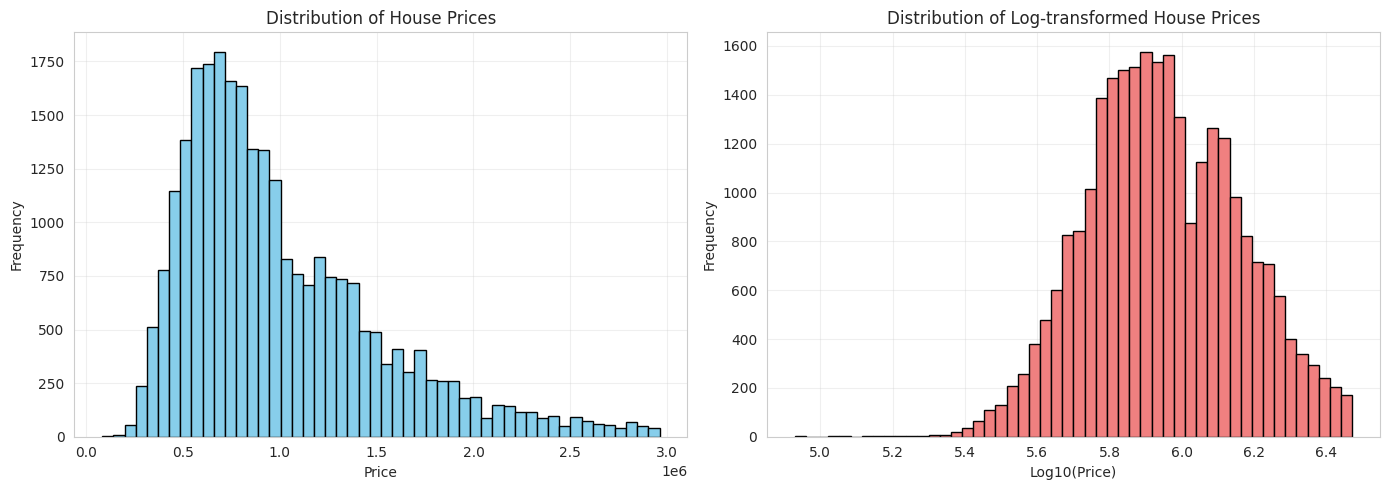

Price distribution plots saved



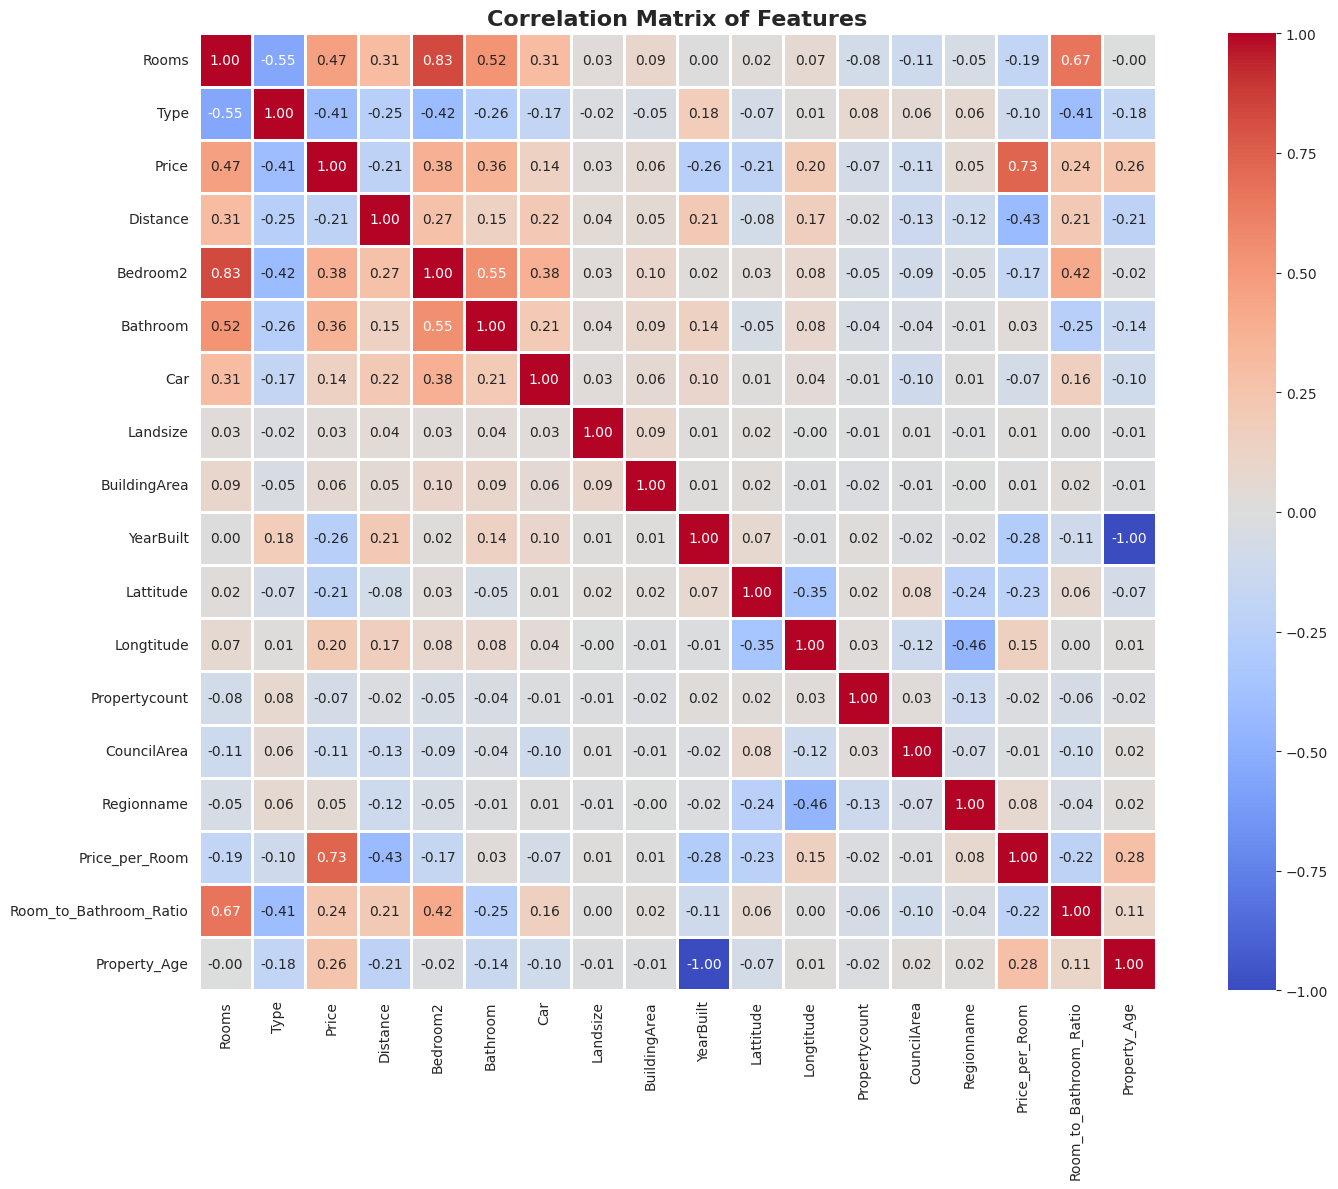

Correlation matrix saved


Top 10 features correlated with Price:
Price                     1.000000
Price_per_Room            0.728841
Rooms                     0.468660
Bedroom2                  0.379878
Bathroom                  0.361017
Property_Age              0.257268
Room_to_Bathroom_Ratio    0.235088
Longtitude                0.195624
Car                       0.135428
BuildingArea              0.060511
Name: Price, dtype: float64


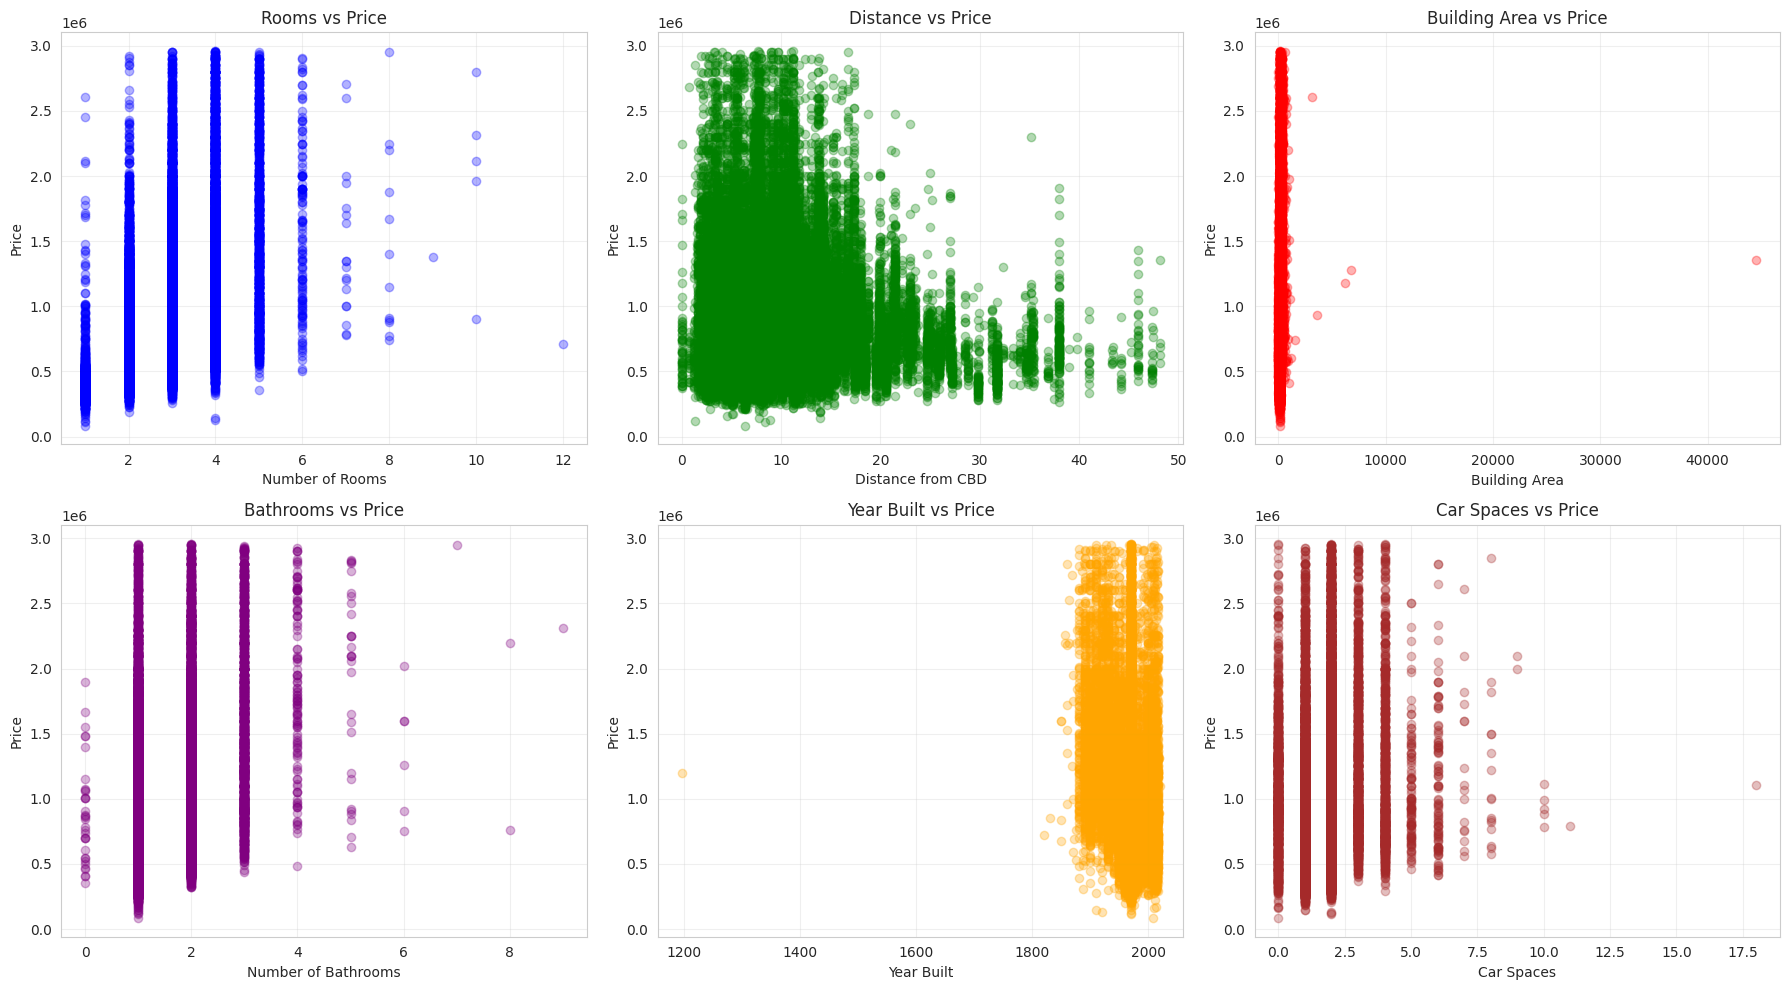

Feature relationship plots saved


In [37]:
# =============================================================================
# 5. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
print(f"\n{'='*60}")
print("EXPLORATORY DATA ANALYSIS")
print(f"{'='*60}")

# 5.1 Price Distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df_clean['Price'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(np.log10(df_clean['Price']), bins=50, color='lightcoral', edgecolor='black')
plt.xlabel('Log10(Price)')
plt.ylabel('Frequency')
plt.title('Distribution of Log-transformed House Prices')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Price distribution plots saved\n")

# 5.2 Correlation Matrix
plt.figure(figsize=(16, 12))
correlation_matrix = df_clean.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation matrix saved\n")

# Top correlations with Price
price_corr = correlation_matrix['Price'].sort_values(ascending=False)
print("\nTop 10 features correlated with Price:")
print(price_corr.head(10))

# 5.3 Key Feature Relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Rooms vs Price
axes[0, 0].scatter(df_clean['Rooms'], df_clean['Price'], alpha=0.3, color='blue')
axes[0, 0].set_xlabel('Number of Rooms')
axes[0, 0].set_ylabel('Price')
axes[0, 0].set_title('Rooms vs Price')
axes[0, 0].grid(True, alpha=0.3)

# Distance vs Price
axes[0, 1].scatter(df_clean['Distance'], df_clean['Price'], alpha=0.3, color='green')
axes[0, 1].set_xlabel('Distance from CBD')
axes[0, 1].set_ylabel('Price')
axes[0, 1].set_title('Distance vs Price')
axes[0, 1].grid(True, alpha=0.3)

# BuildingArea vs Price
axes[0, 2].scatter(df_clean['BuildingArea'], df_clean['Price'], alpha=0.3, color='red')
axes[0, 2].set_xlabel('Building Area')
axes[0, 2].set_ylabel('Price')
axes[0, 2].set_title('Building Area vs Price')
axes[0, 2].grid(True, alpha=0.3)

# Bathroom vs Price
axes[1, 0].scatter(df_clean['Bathroom'], df_clean['Price'], alpha=0.3, color='purple')
axes[1, 0].set_xlabel('Number of Bathrooms')
axes[1, 0].set_ylabel('Price')
axes[1, 0].set_title('Bathrooms vs Price')
axes[1, 0].grid(True, alpha=0.3)

# YearBuilt vs Price
axes[1, 1].scatter(df_clean['YearBuilt'], df_clean['Price'], alpha=0.3, color='orange')
axes[1, 1].set_xlabel('Year Built')
axes[1, 1].set_ylabel('Price')
axes[1, 1].set_title('Year Built vs Price')
axes[1, 1].grid(True, alpha=0.3)

# Car vs Price
axes[1, 2].scatter(df_clean['Car'], df_clean['Price'], alpha=0.3, color='brown')
axes[1, 2].set_xlabel('Car Spaces')
axes[1, 2].set_ylabel('Price')
axes[1, 2].set_title('Car Spaces vs Price')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature relationship plots saved")

In [38]:
# =============================================================================
# 6. DATA FOR MODELING
# =============================================================================
print(f"\n{'='*60}")
print("DATA FOR MODELING")
print(f"{'='*60}")

# Separate features and target
X = df_clean.drop('Price', axis=1)
y = df_clean['Price']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")


DATA FOR MODELING
Features shape: (26773, 17)
Target shape: (26773,)

Training set size: 21418
Testing set size: 5355
Features scaled using StandardScaler


In [39]:
# =============================================================================
# 7. MODEL DEVELOPMENT
# =============================================================================
print(f"\n{'='*60}")
print("MODEL DEVELOPMENT")
print(f"{'='*60}")

# Dictionary to store models and results
models = {}
results = {}

# 7.1 Baseline Model: Linear Regression
print("\n7.1 Training Baseline Model: Linear Regression")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
models['Linear Regression'] = lr_model

y_pred_lr = lr_model.predict(X_test_scaled)
results['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'R2': r2_score(y_test, y_pred_lr)
}
print("Linear Regression trained")

# 7.2 Ridge Regression
print("\n7.2 Training Ridge Regression")
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
models['Ridge Regression'] = ridge_model

y_pred_ridge = ridge_model.predict(X_test_scaled)
results['Ridge Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_ridge),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'R2': r2_score(y_test, y_pred_ridge)
}
print("Ridge Regression trained")

# 7.3 Random Forest (Improved Model)
print("\n7.3 Training Random Forest Regressor")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model

y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'R2': r2_score(y_test, y_pred_rf)
}
print("Random Forest trained")

# 7.4 Gradient Boosting (Optimized Model)
print("\n7.4 Training Gradient Boosting Regressor")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)
models['Gradient Boosting'] = gb_model

y_pred_gb = gb_model.predict(X_test)
results['Gradient Boosting'] = {
    'MAE': mean_absolute_error(y_test, y_pred_gb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gb)),
    'R2': r2_score(y_test, y_pred_gb)
}
print("Gradient Boosting trained")



MODEL DEVELOPMENT

7.1 Training Baseline Model: Linear Regression
Linear Regression trained

7.2 Training Ridge Regression
Ridge Regression trained

7.3 Training Random Forest Regressor
Random Forest trained

7.4 Training Gradient Boosting Regressor
Gradient Boosting trained


In [40]:
# =============================================================================
# 7.5 VERIFICATION: Check if models are trained
# =============================================================================
print(f"\n{'='*60}")
print("VERIFICATION: MODELS TRAINING CHECK")
print(f"{'='*60}")

print("\n1. Checking model attributes:")
print(f"  Linear Regression - Trained: {hasattr(lr_model, 'coef_')}")
print(f"  Ridge Regression  - Trained: {hasattr(ridge_model, 'coef_')}")
print(f"  Random Forest     - Trained: {hasattr(rf_model, 'estimators_')}")
print(f"  Gradient Boosting - Trained: {hasattr(gb_model, 'estimators_')}")

print("\n2. Training scores (R² on training data):")
print(f"  Linear Regression:  {lr_model.score(X_train_scaled, y_train):.4f}")
print(f"  Ridge Regression:   {ridge_model.score(X_train_scaled, y_train):.4f}")
print(f"  Random Forest:      {rf_model.score(X_train, y_train):.4f}")
print(f"  Gradient Boosting:  {gb_model.score(X_train, y_train):.4f}")

print("\n3. Test predictions on one sample:")
test_sample = X_test.iloc[0:1]
test_sample_scaled = scaler.transform(test_sample)
actual_price = y_test.iloc[0]

print(f"  Actual Price: ${actual_price:,.0f}")
print(f"  LR Prediction:  ${lr_model.predict(test_sample_scaled)[0]:,.0f}")
print(f"  Ridge Prediction: ${ridge_model.predict(test_sample_scaled)[0]:,.0f}")
print(f"  RF Prediction:  ${rf_model.predict(test_sample)[0]:,.0f}")
print(f"  GB Prediction:  ${gb_model.predict(test_sample)[0]:,.0f}")

print("\n4. Model parameters:")
print(f"  Random Forest - Trees: {rf_model.n_estimators}, Max Depth: {rf_model.max_depth}")
print(f"  Gradient Boosting - Trees: {gb_model.n_estimators}, Learning Rate: {gb_model.learning_rate}")



VERIFICATION: MODELS TRAINING CHECK

1. Checking model attributes:
  Linear Regression - Trained: True
  Ridge Regression  - Trained: True
  Random Forest     - Trained: True
  Gradient Boosting - Trained: True

2. Training scores (R² on training data):
  Linear Regression:  0.9238
  Ridge Regression:   0.9238
  Random Forest:      0.9999
  Gradient Boosting:  0.9998

3. Test predictions on one sample:
  Actual Price: $350,000
  LR Prediction:  $276,463
  Ridge Prediction: $276,438
  RF Prediction:  $350,170
  GB Prediction:  $348,511

4. Model parameters:
  Random Forest - Trees: 100, Max Depth: 20
  Gradient Boosting - Trees: 100, Learning Rate: 0.1



MODEL EVALUATION AND COMPARISON

Model Performance Comparison:
                        MAE       RMSE   R2
Linear Regression  88704.36  158873.37  0.9
Ridge Regression   88706.68  158870.15  0.9
Random Forest       1689.14   22503.59  1.0
Gradient Boosting   5499.48   16845.01  1.0


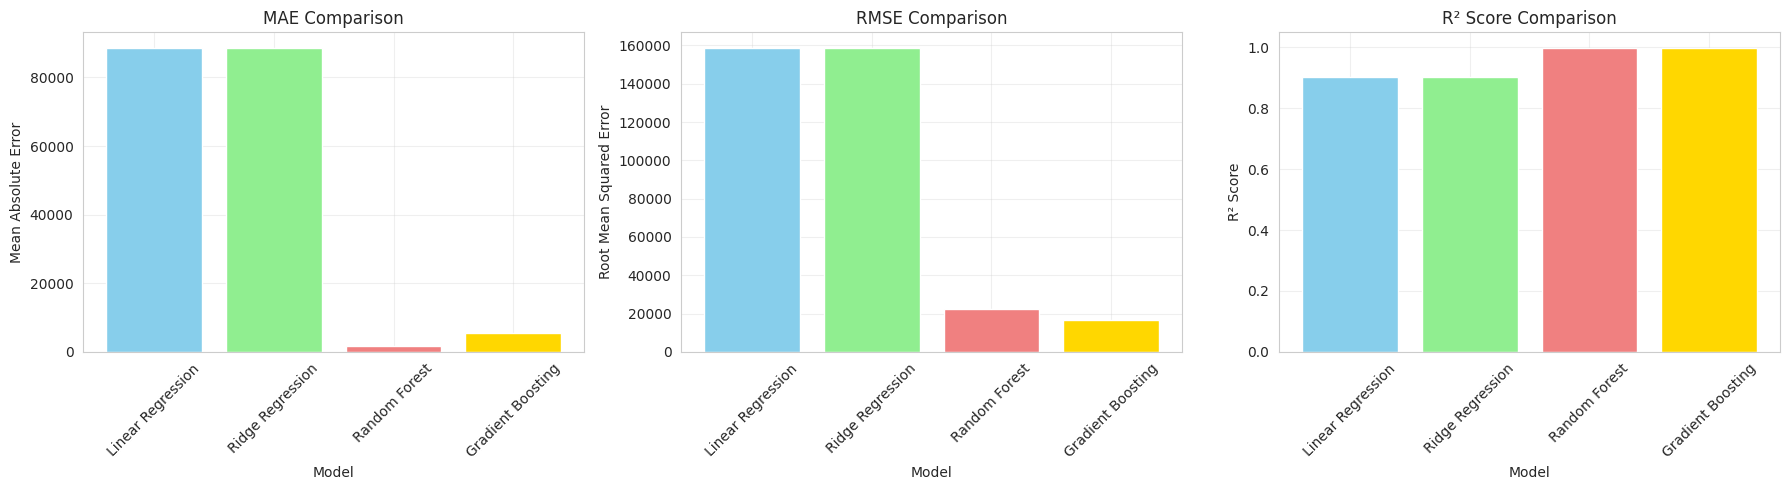

In [41]:
# =============================================================================
# 8. MODEL EVALUATION AND COMPARISON
# =============================================================================
print(f"\n{'='*60}")
print("MODEL EVALUATION AND COMPARISON")
print(f"{'='*60}")

# Create results dataframe
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df.round(2))

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE Comparison
axes[0].bar(results_df.index, results_df['MAE'], color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_title('MAE Comparison')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# RMSE Comparison
axes[1].bar(results_df.index, results_df['RMSE'], color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Root Mean Squared Error')
axes[1].set_title('RMSE Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# R² Comparison
axes[2].bar(results_df.index, results_df['R2'], color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
axes[2].set_xlabel('Model')
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Score Comparison')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features (Average across all models):
                   Feature   Average  Random Forest  Gradient Boosting
14          Price_per_Room  0.543740       0.667071           0.644819
0                    Rooms  0.270677       0.330024           0.354427
15  Room_to_Bathroom_Ratio  0.060688       0.002533           0.000667
4                 Bathroom  0.054181       0.000012           0.000003
2                 Distance  0.018697       0.000016           0.000029
10              Longtitude  0.010193       0.000018           0.000007
12             CouncilArea  0.008760       0.000011           0.000001
9                Lattitude  0.006497       0.000012           0.000002
3                 Bedroom2  0.006042       0.000195           0.000002
13              Regionname  0.004625       0.000004           0.000014


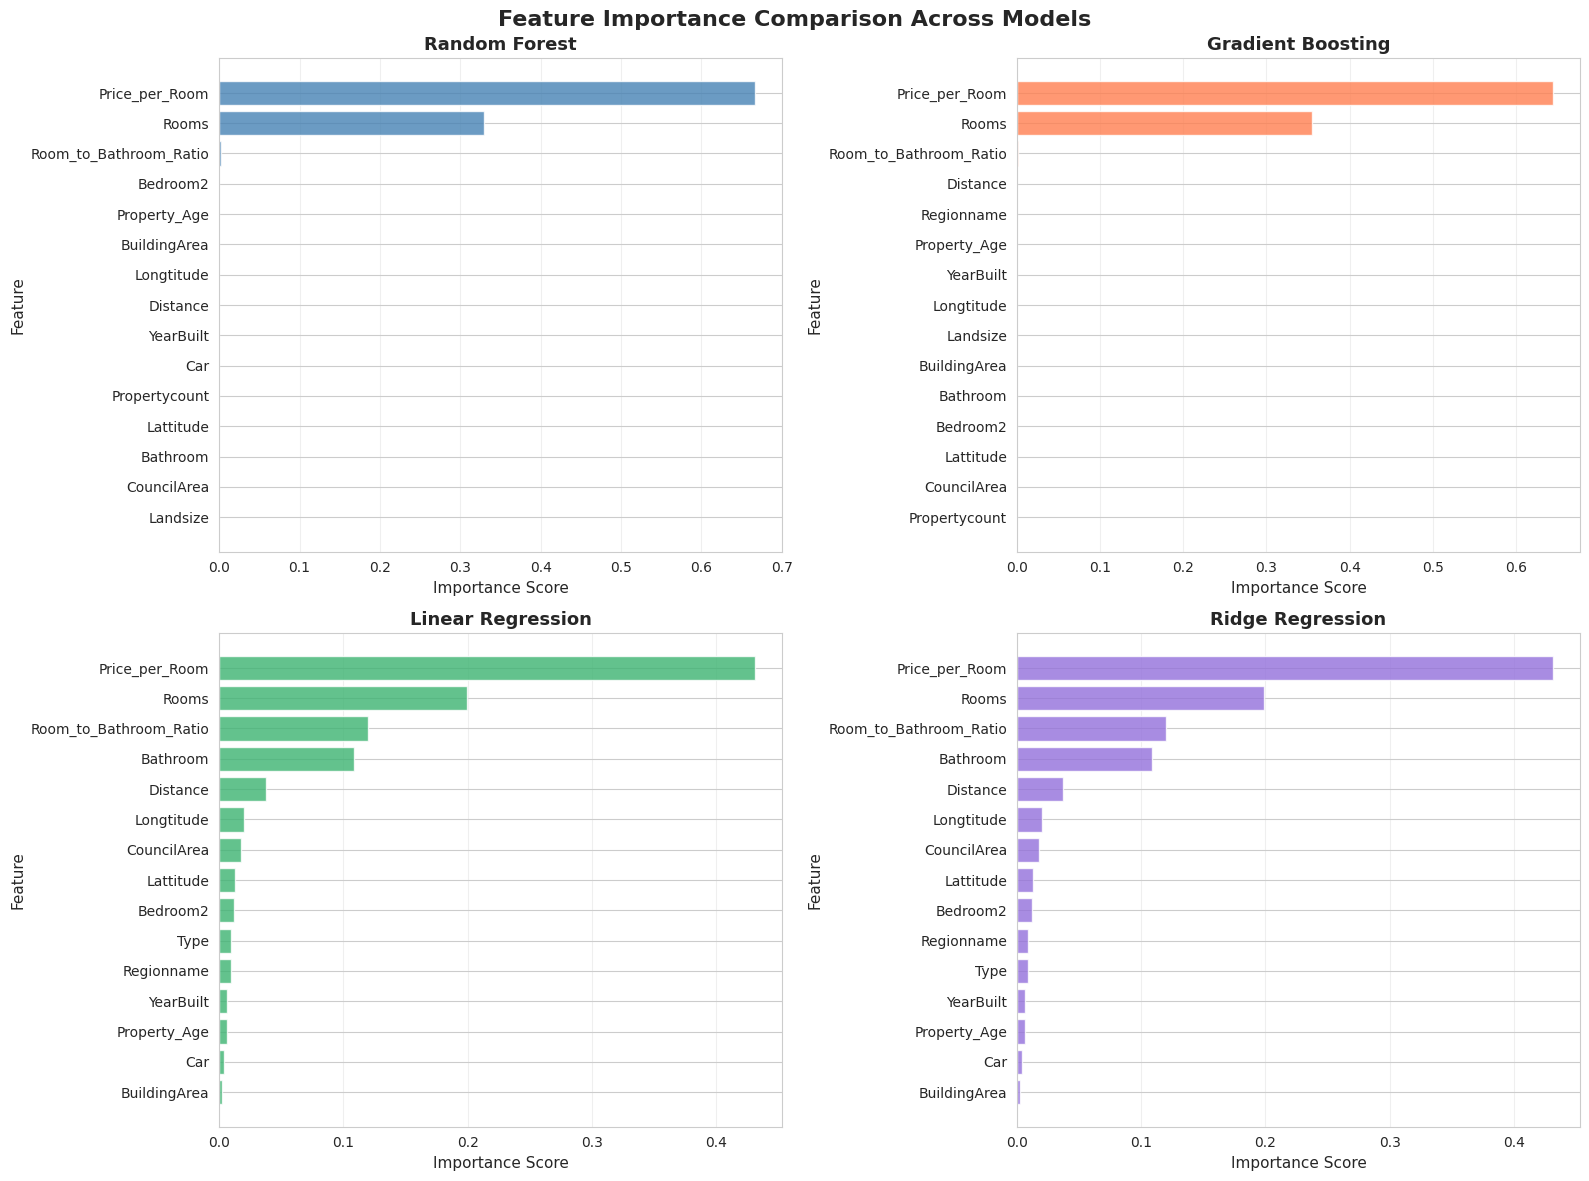

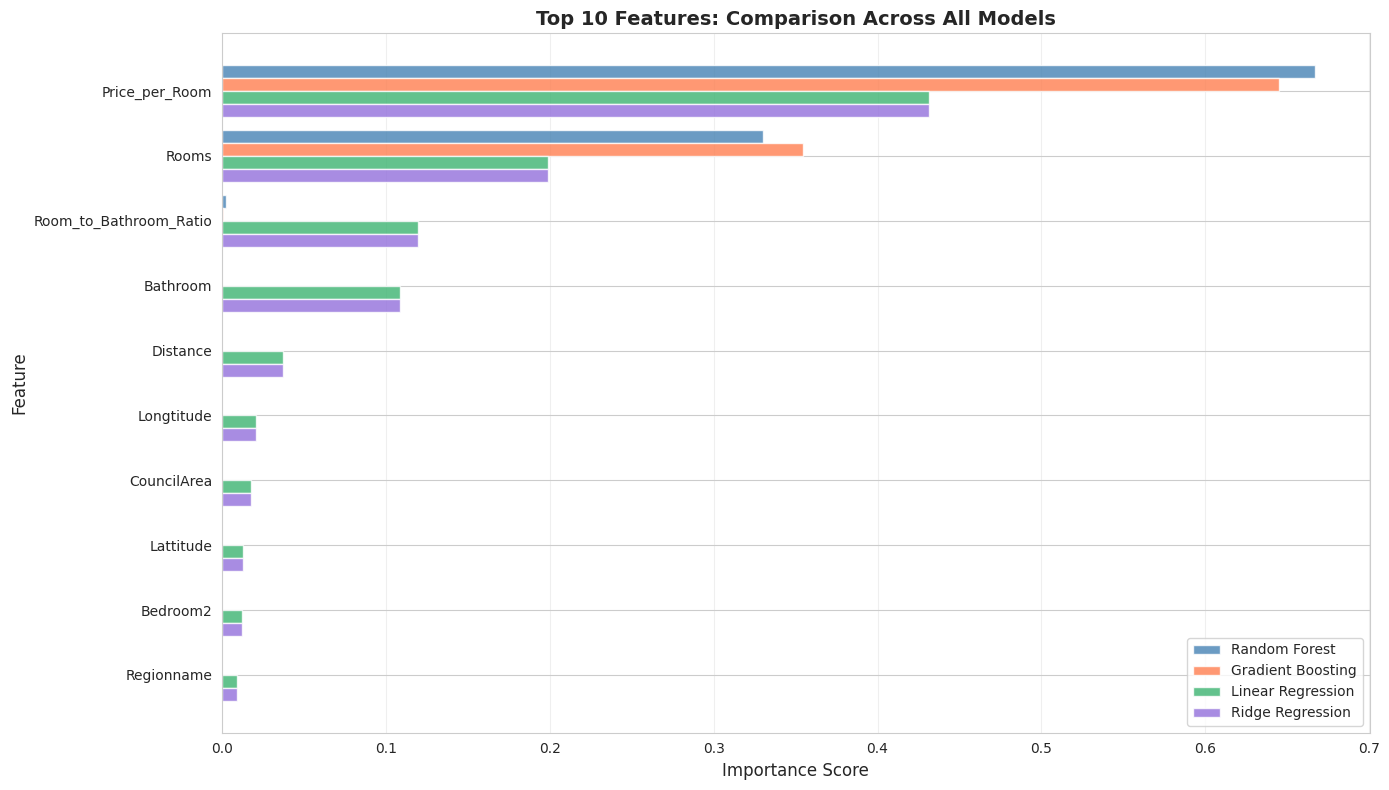

In [44]:
# =============================================================================
# 9. FEATURE IMPORTANCE
# =============================================================================
print(f"\n{'='*60}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*60}")

# Creating a DataFrame to store the importance of features
importance_df = pd.DataFrame({'Feature': X.columns})

# 1. Random Forest
importance_df['Random Forest'] = rf_model.feature_importances_

# 2. Gradient Boosting
importance_df['Gradient Boosting'] = gb_model.feature_importances_

# 3. Linear Regression (absolute values of coefficients)
# Normalize so that the sum is 1.0
lr_coef_abs = np.abs(lr_model.coef_)
importance_df['Linear Regression'] = lr_coef_abs / lr_coef_abs.sum()

# 4. Ridge Regression
ridge_coef_abs = np.abs(ridge_model.coef_)
importance_df['Ridge Regression'] = ridge_coef_abs / ridge_coef_abs.sum()

# Сalculate the average importance for all models
importance_df['Average'] = importance_df[['Random Forest', 'Gradient Boosting',  'Linear Regression', 'Ridge Regression']].mean(axis=1)

# Sort by average importance
importance_df = importance_df.sort_values('Average', ascending=False)

print("\nTop 10 Most Important Features (Average across all models):")
print(importance_df[['Feature', 'Average', 'Random Forest', 'Gradient Boosting']].head(10))

# =============================================================================
# Visualization
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Importance Comparison Across Models', fontsize=16, fontweight='bold')

models_to_plot = ['Random Forest', 'Gradient Boosting', 'Linear Regression', 'Ridge Regression']
colors = ['steelblue', 'coral', 'mediumseagreen', 'mediumpurple']

for idx, (model_name, color) in enumerate(zip(models_to_plot, colors)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    # Sorting by importance for each model separately
    top_features = importance_df.nlargest(15, model_name)

    ax.barh(top_features['Feature'], top_features[model_name], color=color, alpha=0.8)
    ax.set_xlabel('Importance Score', fontsize=11)
    ax.set_ylabel('Feature', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparison of the top 10 signs
plt.figure(figsize=(14, 8))
top10 = importance_df.head(10)

x = np.arange(len(top10))
width = 0.2

plt.barh(x - 1.5*width, top10['Random Forest'], width, label='Random Forest', color='steelblue', alpha=0.8)
plt.barh(x - 0.5*width, top10['Gradient Boosting'], width, label='Gradient Boosting', color='coral', alpha=0.8)
plt.barh(x + 0.5*width, top10['Linear Regression'], width, label='Linear Regression', color='mediumseagreen', alpha=0.8)
plt.barh(x + 1.5*width, top10['Ridge Regression'], width, label='Ridge Regression', color='mediumpurple', alpha=0.8)

plt.yticks(x, top10['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Features: Comparison Across All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


PREDICTION VISUALIZATION

Best performing model: Gradient Boosting
R² Score: 0.9989


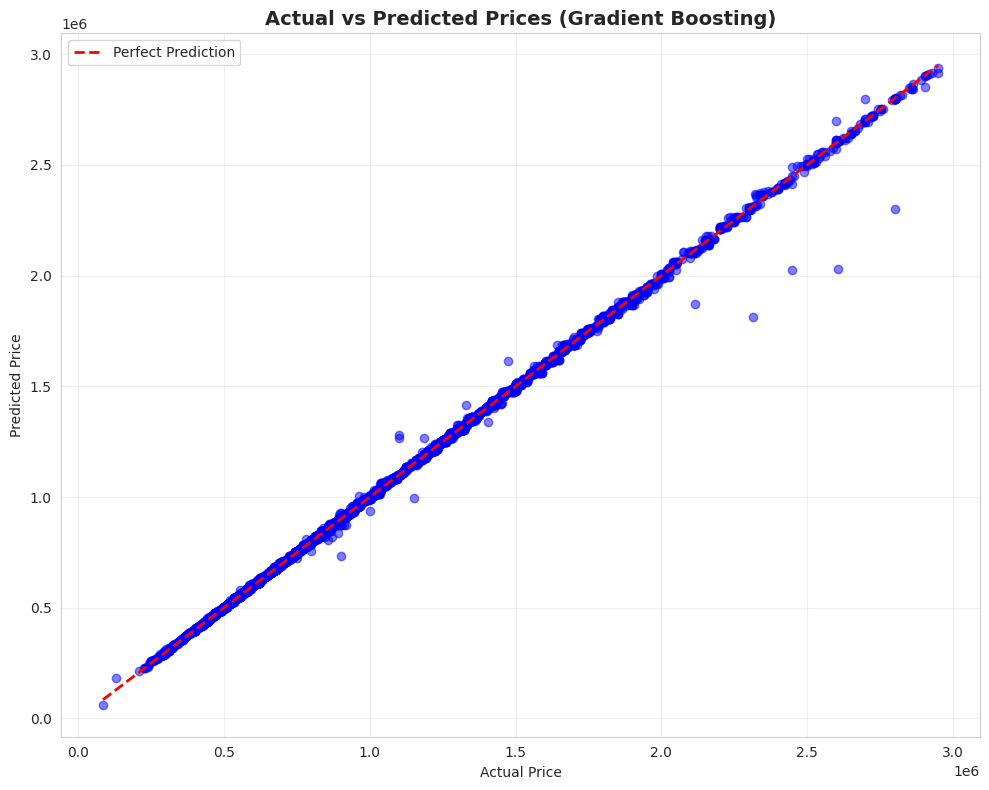

In [45]:
# =============================================================================
# 10. PREDICTION VISUALIZATION
# =============================================================================
print(f"\n{'='*60}")
print("PREDICTION VISUALIZATION")
print(f"{'='*60}")

# Use best model (Random Forest based on R²)
best_model_name = results_df['R2'].idxmax()
print(f"\nBest performing model: {best_model_name}")
print(f"R² Score: {results_df.loc[best_model_name, 'R2']:.4f}")

# Actual vs Predicted for best model
if best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf
elif best_model_name == 'Gradient Boosting':
    y_pred_best = y_pred_gb
elif best_model_name == 'Ridge Regression':
    y_pred_best = y_pred_ridge
else:
    y_pred_best = y_pred_lr

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Prices ({best_model_name})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()



RESIDUAL ANALYSIS

Residual Statistics:
  Mean:     $463.39
  Median:   $-158.64
  Std Dev:  $16,840.21
  Min:      $-182,177.19
  Max:      $574,874.84

Normality Test (p-value): 0.0000
  Residuals may not be normally distributed


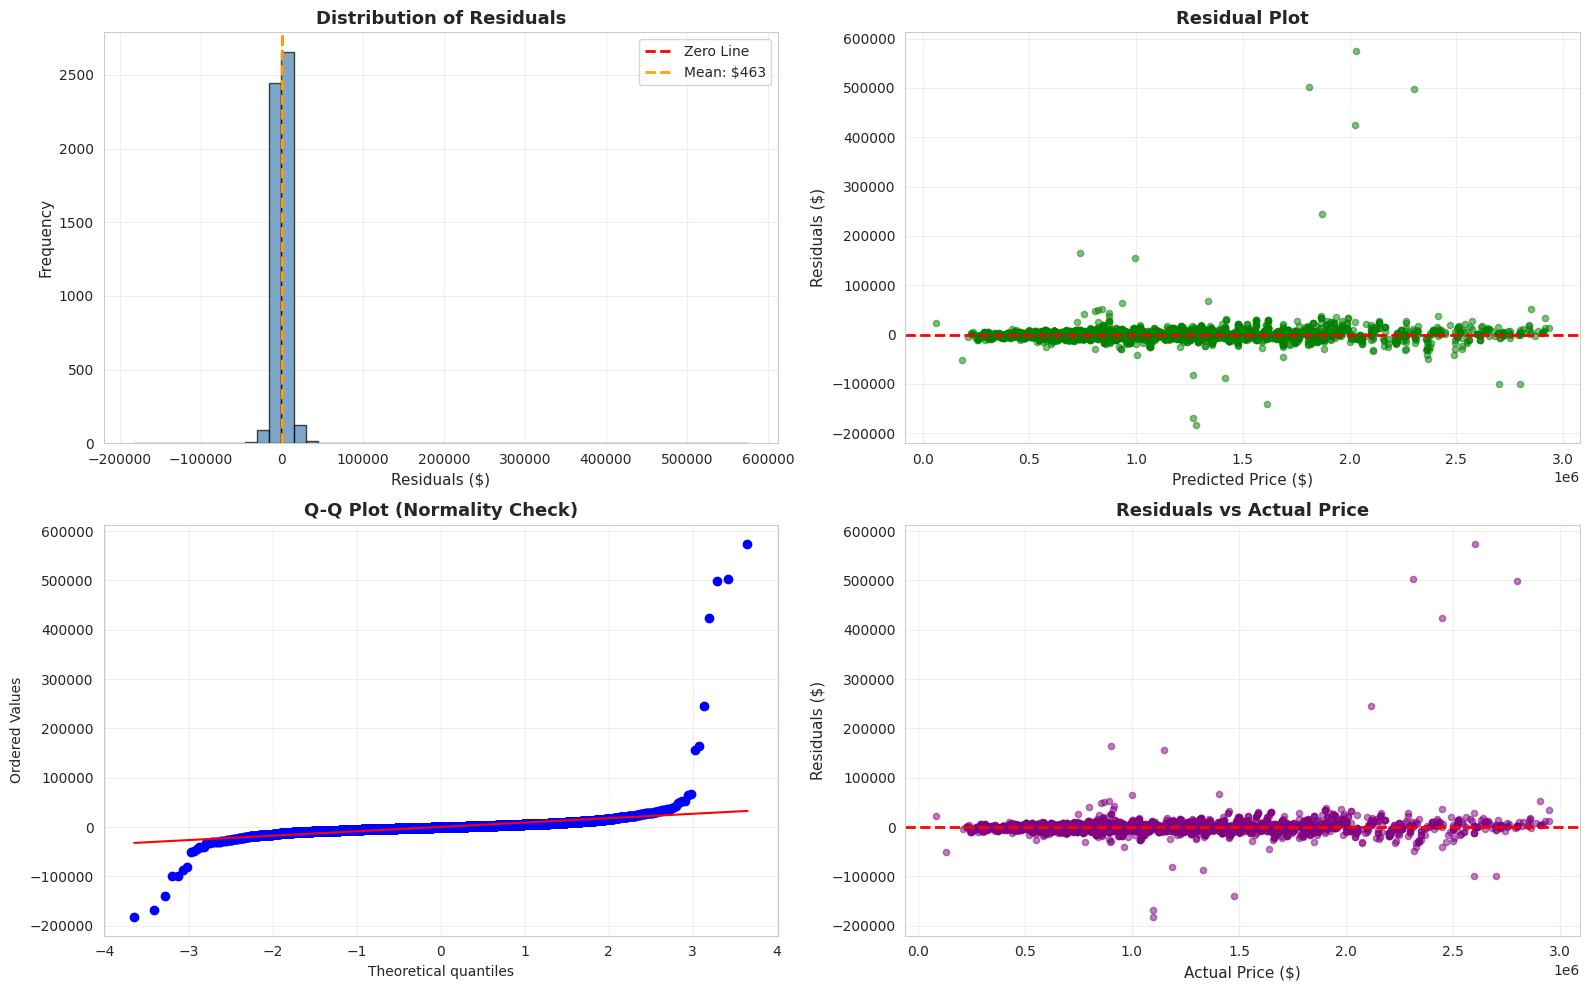

In [47]:
# =============================================================================
# 11. RESIDUAL ANALYSIS
# =============================================================================
print(f"\n{'='*60}")
print("RESIDUAL ANALYSIS")
print(f"{'='*60}")

residuals = y_test - y_pred_best

# Statistics remaining
print(f"\nResidual Statistics:")
print(f"  Mean:     ${residuals.mean():,.2f}")
print(f"  Median:   ${residuals.median():,.2f}")
print(f"  Std Dev:  ${residuals.std():,.2f}")
print(f"  Min:      ${residuals.min():,.2f}")
print(f"  Max:      ${residuals.max():,.2f}")

# Checking for normality
from scipy import stats
_, p_value = stats.normaltest(residuals)
print(f"\nNormality Test (p-value): {p_value:.4f}")
if p_value > 0.05:
    print("  Residuals appear normally distributed")
else:
    print("  Residuals may not be normally distributed")

# Visualization
fig = plt.figure(figsize=(16, 10))

# 1. Histogram
ax1 = plt.subplot(2, 2, 1)
ax1.hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', lw=2, label='Zero Line')
ax1.axvline(x=residuals.mean(), color='orange', linestyle='--', lw=2, label=f'Mean: ${residuals.mean():,.0f}')
ax1.set_xlabel('Residuals ($)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Residuals', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residual Plot
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(y_pred_best, residuals, alpha=0.5, color='green', s=20)
ax2.axhline(y=0, color='red', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Price ($)', fontsize=11)
ax2.set_ylabel('Residuals ($)', fontsize=11)
ax2.set_title('Residual Plot', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Q-Q Plot (checking for normality)
ax3 = plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Normality Check)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Residuals vs Actual Price
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(y_test, residuals, alpha=0.5, color='purple', s=20)
ax4.axhline(y=0, color='red', linestyle='--', lw=2)
ax4.set_xlabel('Actual Price ($)', fontsize=11)
ax4.set_ylabel('Residuals ($)', fontsize=11)
ax4.set_title('Residuals vs Actual Price', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis_extended.png', dpi=300, bbox_inches='tight')
plt.show()


In [49]:
# =============================================================================
# 12. SAVE CLEANED DATASET
# =============================================================================

df_clean.to_csv('Melbourne_housing_CLEANED.csv', index=False)
print("Cleaned dataset saved as 'Melbourne_housing_CLEANED.csv'")

Cleaned dataset saved as 'Melbourne_housing_CLEANED.csv'


In [22]:
%cd /content

import shutil
shutil.rmtree("/content/House-Price-Prediction", ignore_errors=True)

!git clone https://github.com/MadiyarAga/House-Price-Prediction.git

import os

repo_path = "/content/House-Price-Prediction"
clean_csv_path = os.path.join(repo_path, "melbourne_house_cleaned_dataset.csv")
df_clean.to_csv(clean_csv_path, index=False)
print("Cleaned dataset saved to:", clean_csv_path)


/content
Cloning into 'House-Price-Prediction'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), 900.93 KiB | 3.87 MiB/s, done.
Cleaned dataset saved to: /content/House-Price-Prediction/melbourne_house_cleaned_dataset.csv


In [24]:
%cd /content/House-Price-Prediction

!git config user.email "@gmail.com"
!git config user.name ""

!git add melbourne_house_cleaned_dataset.csv
!git commit -m "Add cleaned Melbourne housing dataset"

TOKEN = ""
!git push https://{TOKEN}@github.com/MadiyarAga/House-Price-Prediction.git main


/content/House-Price-Prediction
[main fa3d194] Add cleaned Melbourne housing dataset
 1 file changed, 26774 insertions(+)
 create mode 100644 melbourne_house_cleaned_dataset.csv
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 555.89 KiB | 1.24 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/MadiyarAga/House-Price-Prediction.git
   7f104ef..fa3d194  main -> main
